### Import and Load model

In [1]:
import time
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 

import torch
from torch import nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn

from utils.plots import plot_pr,plot_roc, plot_dist, plot_violin
from utils.metircs import accuracy,mutual_info,nll, ece, Shannon_entropy
from utils.visual import ProgressMeter, AverageMeter, Summary
from data_utils.get_datasets import get_dataset
from model_utils.get_models import get_model
from uncertainty.mc_dropout import mc_dropout_predict
from uncertainty.test_time_aug import test_time_aug_predict
from uncertainty.deep_ensemble import deep_ensembel_predict,EnsembleModel
from uncertainty.baseline_softmax import baseline_softmax_predict
from uncertainty.bnn_svi import bnn_svi_predict
from adversarial.adversarial_attack import fgsm_attack, pgd_attack

/share/home/shiqing/miniconda3/envs/yym/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0')
model = get_model("vgg16", 10, use_torchvision=False)
model = model.to(device)
model.eval()
checkpoint = torch.load("../saved_models/deterministic/vgg16/2023_11_24_15_25_21/vgg16_best_model_93.62.pth")
model.load_state_dict(checkpoint['state_dict'])

use private models...


<All keys matched successfully>

In [3]:
summary(model,(3,32,32))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [4]:
#random Gaussian noise fed into an image classifier gives a “prediction confidence” or predicted class probability of 91%
noise = torch.randn(64,3,32,32).to(device)
prob = torch.softmax(model(noise), axis=1)
print(torch.max(prob,axis=1))

torch.return_types.max(
values=tensor([0.7043, 0.4592, 0.7171, 0.4833, 0.5913, 0.8483, 0.5534, 0.7414, 0.4121,
        0.6422, 0.7523, 0.4289, 0.4483, 0.3970, 0.5404, 0.4943, 0.3730, 0.4176,
        0.6540, 0.5251, 0.4751, 0.5551, 0.5368, 0.5525, 0.6221, 0.4799, 0.6685,
        0.5170, 0.5511, 0.6157, 0.5527, 0.3688, 0.5451, 0.4574, 0.3569, 0.4301,
        0.7016, 0.6423, 0.4996, 0.3893, 0.5686, 0.5242, 0.6615, 0.5282, 0.4153,
        0.4298, 0.4647, 0.6671, 0.4289, 0.6227, 0.5344, 0.5662, 0.5959, 0.6127,
        0.5377, 0.5370, 0.5059, 0.6887, 0.6362, 0.4418, 0.3732, 0.4757, 0.5786,
        0.4752], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 6, 6, 6, 2, 2, 4, 4, 4, 4, 4, 6, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 2, 6, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4,
        6, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 6, 6, 4, 4], device='cuda:0'))


### Baseline softmax

In [5]:
%reload_ext autoreload
%autoreload 2

In [ ]:
datanames = [ "cifar10", "mnist","fashionmnist","svhn"]
probs_list = []
targets_list = []
for dataname in datanames:
    val_transform = transforms.Compose(
        [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
        ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(2,transforms.Lambda(lambda x:x.repeat(3,1,1)))
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)
    
    probs ,targets= baseline_softmax_predict(val_loader, model, device)
    probs_list.append(probs.cpu().detach().numpy())
    targets_list.append(targets.cpu().detach().numpy())

 * Time 0.002 Acc@1 93.620


#### misclassified

In [ ]:
cifar10_probs = probs_list[0]
cifar10_target = targets_list[0]

In [ ]:
cifar10_pred = np.argmax(cifar10_probs,axis=1)
labels = (cifar10_pred == cifar10_target).astype(int)#正确分类标为1，误分类标为0
maxp= np.max(cifar10_probs,axis=1)
random_pred = np.random.rand(labels.shape[0])

In [ ]:
succ_maxp_mean = maxp[labels==1].mean()
err_maxp_mean = maxp[labels==0].mean()
print(f"正确分类样本数{labels.sum()},平均预测概率:{succ_maxp_mean:.3f}\n错误分类样本数{(1-labels).sum()},错误分类平均预测概率:{err_maxp_mean:.3f}")

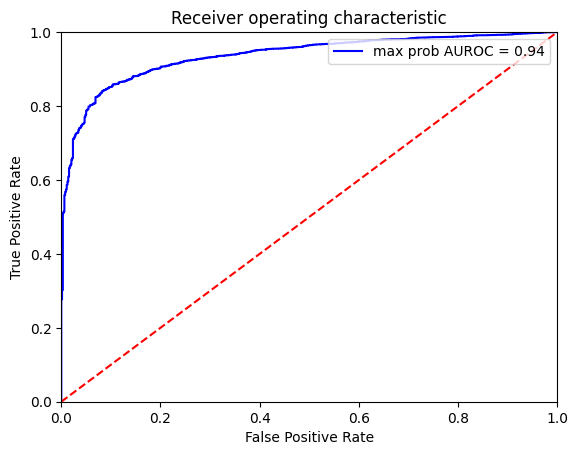

In [10]:
plot_roc(labels,maxp,"max prob")

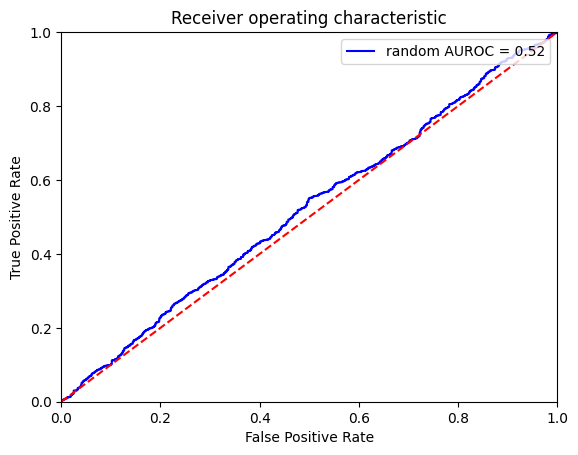

In [11]:
plot_roc(labels,random_pred,"random")

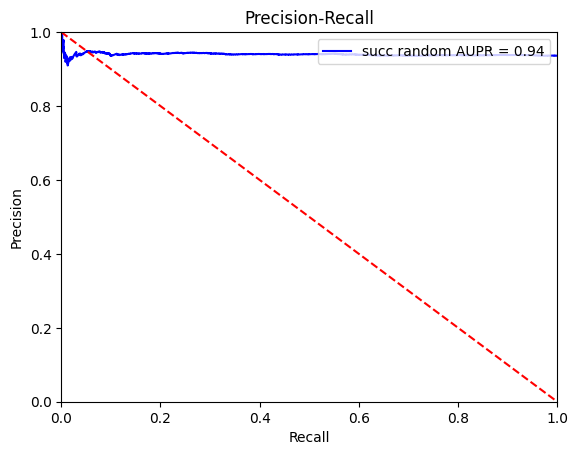

In [12]:
plot_pr(labels,random_pred,"succ random")

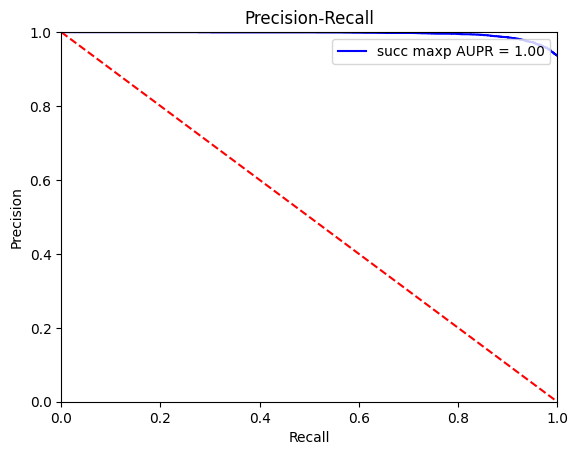

In [13]:
plot_pr(labels,maxp,"succ maxp")

In [14]:
labels2 = (cifar10_pred != cifar10_target).astype(int)#误分类标为1，正确分类标为0
maxp2 = -maxp
random_pred2 = -random_pred

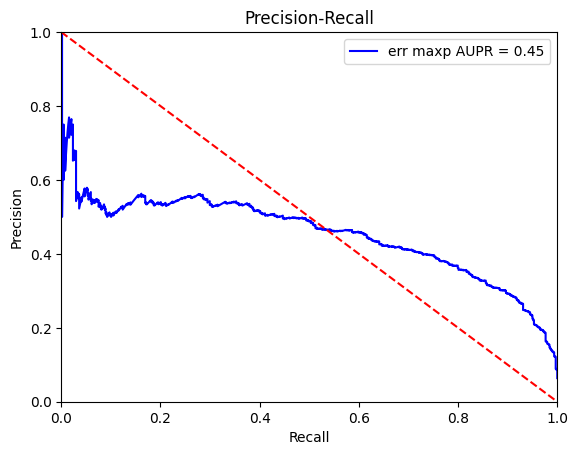

In [15]:
plot_pr(labels2,maxp2,"err maxp")

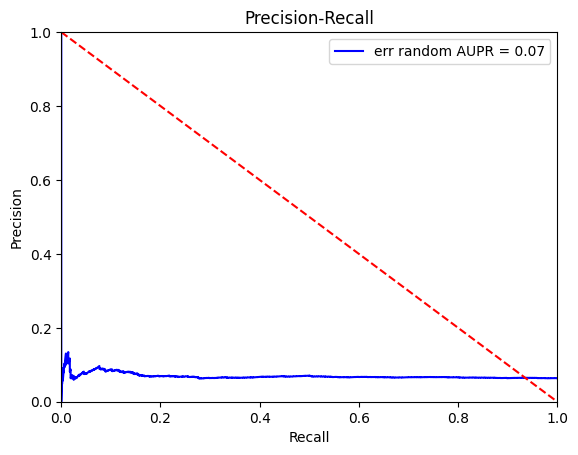

In [16]:
plot_pr(labels2,random_pred2,"err random")

#### OOD

In [17]:
maxp_list = []
for i, probs in enumerate(probs_list):
    maxp_list.append(np.max(probs,axis=1))

In [18]:
entropy_list = []
for i, probs in enumerate(probs_list):
    ent = Shannon_entropy(probs)
    entropy_list.append(ent)

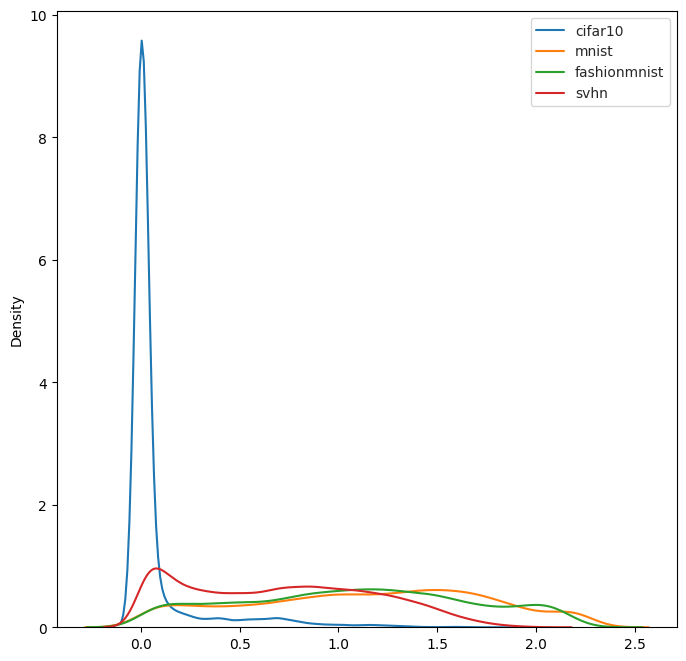

In [19]:
#绘制熵的分布
plot_dist(entropy_list,datanames)

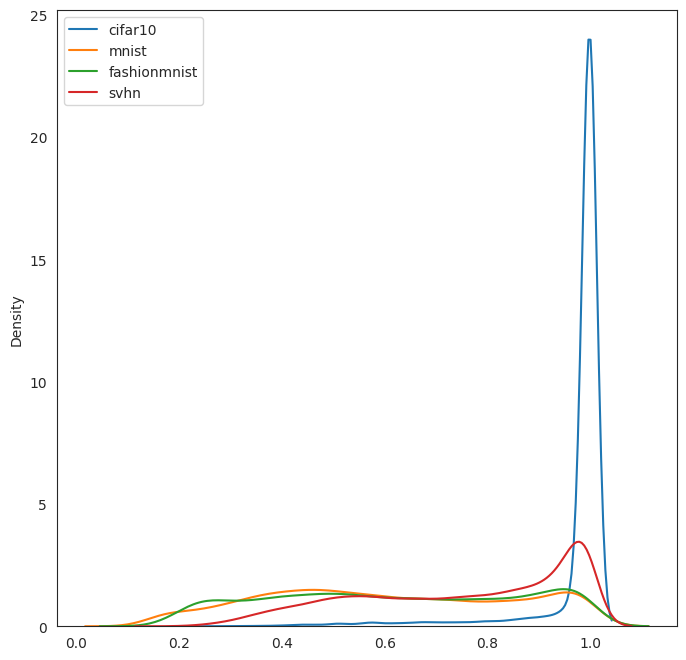

In [20]:
#绘制最大概率的分布
plot_dist(maxp_list,datanames)

In [21]:
#绘制小提琴图
# plot_violin(maxp_list,datanames)

In [22]:
#IND样本视为正样本， mnist样本视为负样本
print(f"cifar10 test nums:{len(maxp_list[0])},mnist test nums:{len(maxp_list[1])}")
y_true = [1]*len(maxp_list[0])+[0]*len(maxp_list[1])
maxp = np.concatenate([maxp_list[0],maxp_list[1]])
random_pred = np.random.rand(len(y_true))

cifar10 test nums:10000,mnist test nums:10000


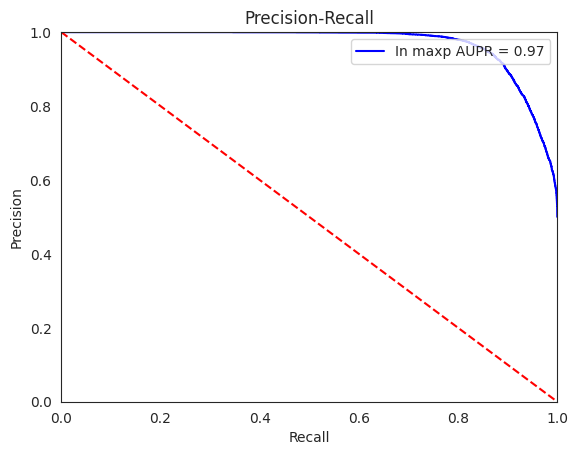

In [23]:
plot_pr(y_true,maxp,"In maxp")

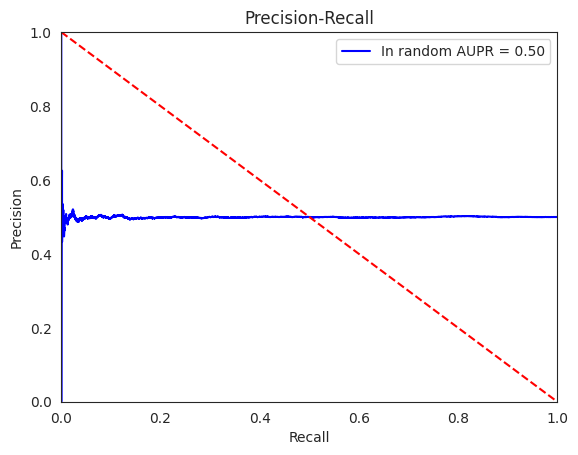

In [24]:
plot_pr(y_true,random_pred,"In random")

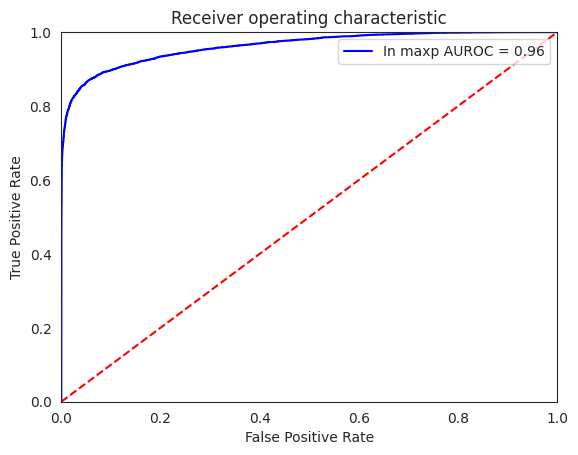

In [25]:
plot_roc(y_true,maxp,"In maxp")

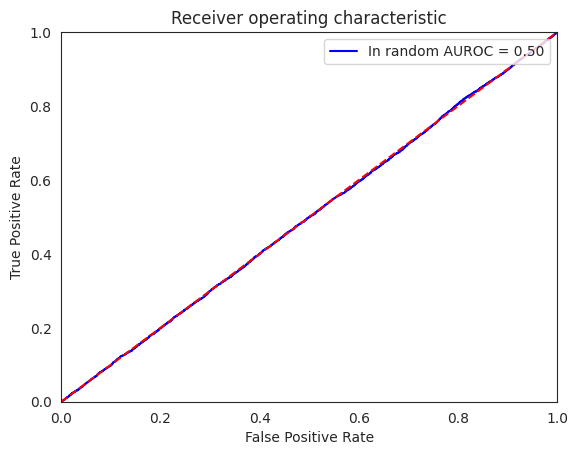

In [26]:
plot_roc(y_true,random_pred,"In random")

In [27]:
#IND样本视为负样本， mnist样本视为正样本
y_true2 = [0]*len(maxp_list[0])+[1]*len(maxp_list[1])
maxp2 = np.concatenate([maxp_list[0],maxp_list[1]])*-1
random_pred2 = - random_pred

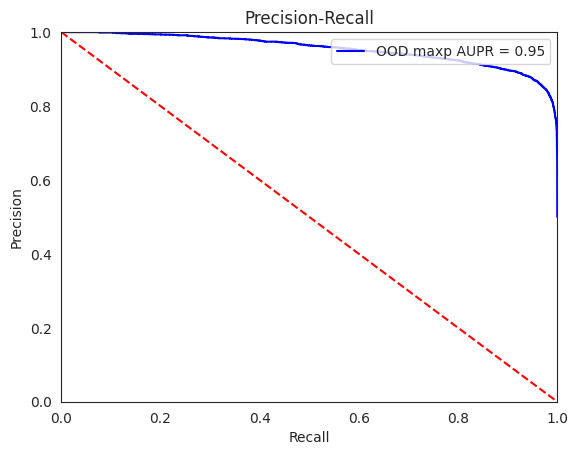

In [28]:
plot_pr(y_true2,maxp2,"OOD maxp")

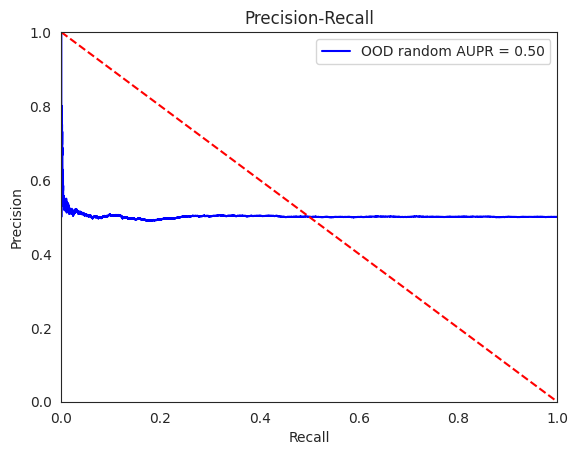

In [29]:
plot_pr(y_true,random_pred2,"OOD random")

#### advasarial attack

In [30]:
_, val_dataset = get_dataset("cifar10","../data",None,val_transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False,
    num_workers=4, pin_memory=True)

In [31]:
adv_probs_list = []
probs_list = []
method = "pgd"
epsilon = 0.01
correct = 0
for images, target in val_loader:
    images, target = images.to(device), target.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    init_prob = torch.softmax(model(images), axis=1)
    clean_prob, init_pred = init_prob.max(1, keepdim=True)
    if init_pred.item() != target.item():
            continue
        
    if method == "fgsm":
        perturbed_images = fgsm_attack(model, images, target, epsilon)
    elif method == "pgd":
        perturbed_images = pgd_attack(model, images, target, epsilon)

    adv_prob = torch.softmax(model(perturbed_images), axis=1)
    _, final_pred = adv_prob.max(1, keepdim=True)
    adv_probs_list.append(adv_prob.cpu().detach().numpy())
    probs_list.append(init_prob.cpu().detach().numpy())

    if final_pred.item() == target.item():
        correct += 1

final_acc = correct/float(len(val_loader))
print(
    f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(val_loader)} = {final_acc}")

Epsilon: 0.01	Test Accuracy = 406 / 10000 = 0.0406


In [32]:
adv_probs = np.concatenate(adv_probs_list,axis=0)
probs = np.concatenate(probs_list,axis=0)

In [33]:
probs

array([[7.37839800e-05, 4.90292405e-05, 1.21164674e-04, ...,
        1.23284235e-05, 1.97397130e-05, 1.42321587e-05],
       [1.28548945e-05, 6.83968938e-06, 6.14247313e-07, ...,
        6.86495639e-07, 9.99970078e-01, 3.88131821e-06],
       [1.01496931e-02, 4.52723682e-01, 2.30381280e-04, ...,
        9.73474889e-05, 5.34760892e-01, 1.16362562e-03],
       ...,
       [3.83587212e-06, 6.30552950e-06, 2.10509097e-05, ...,
        1.66975660e-05, 4.50733023e-06, 3.33515595e-06],
       [8.93753895e-06, 9.99656320e-01, 5.65131159e-05, ...,
        7.53506765e-06, 5.18602428e-05, 3.32730315e-06],
       [2.33836126e-05, 5.41836926e-05, 1.54268510e-05, ...,
        9.99792159e-01, 2.02276860e-05, 1.41951114e-05]], dtype=float32)

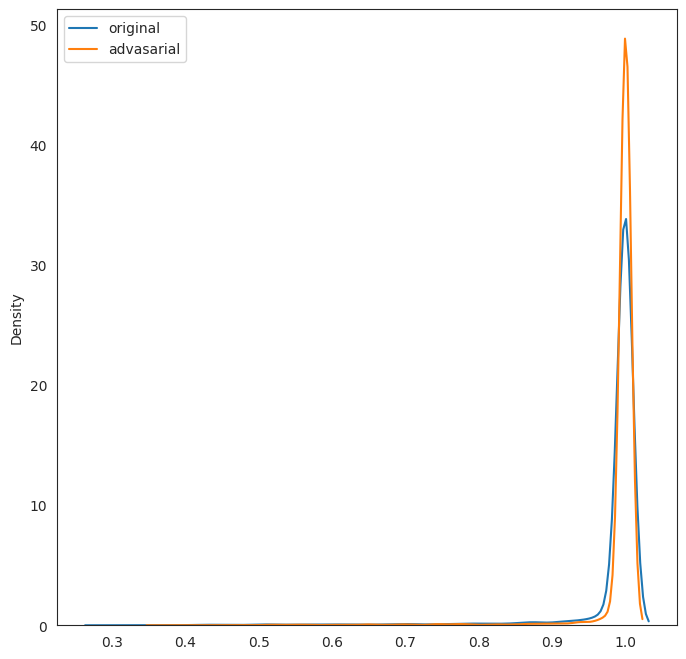

In [34]:
maxp_list = []
for i, probs in enumerate([probs,adv_probs]):
    maxp_list.append(np.max(probs,axis=1))
plot_dist(maxp_list,["original","advasarial"])

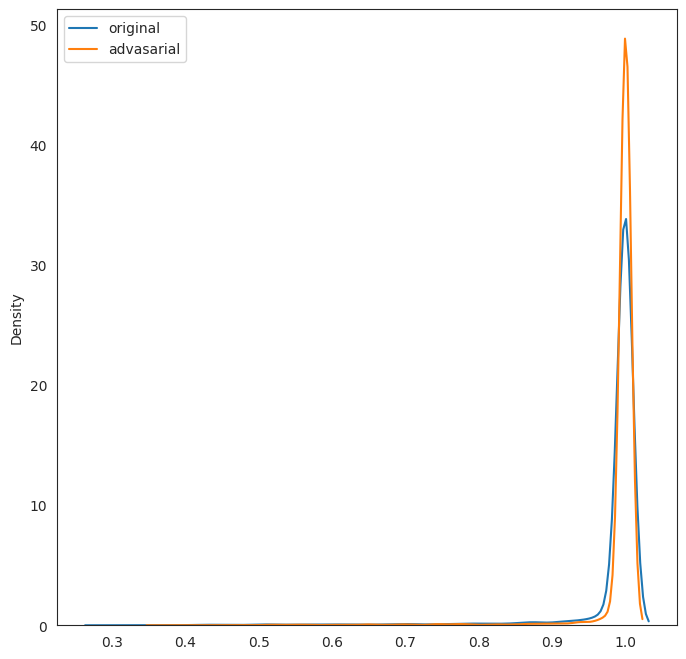

In [35]:
entropy_list = []
for i, probs in enumerate([probs,adv_probs]):
    ent = Shannon_entropy(probs)
    entropy_list.append(ent)
plot_dist(maxp_list,["original","advasarial"])

In [36]:
#原始样本视为正样本， 攻击样本视为负样本
y_true = [1]*len(maxp_list[0])+[0]*len(maxp_list[1])
maxp = np.concatenate([maxp_list[0],maxp_list[1]])
random_pred = np.random.rand(len(y_true))

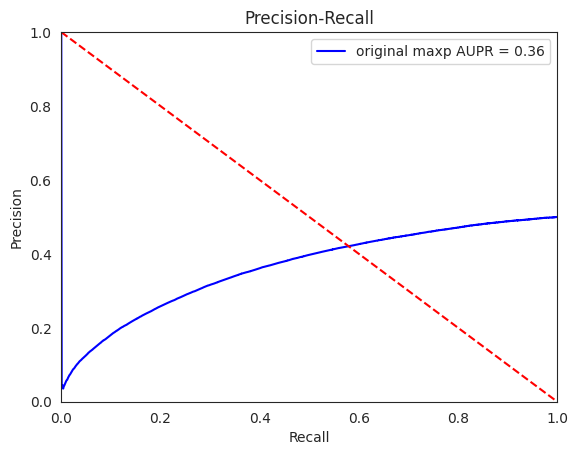

In [37]:
plot_pr(y_true,maxp,"original maxp")

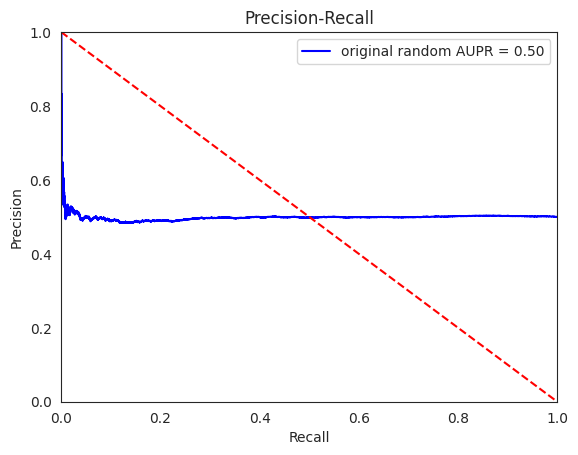

In [38]:
plot_pr(y_true,random_pred,"original random")

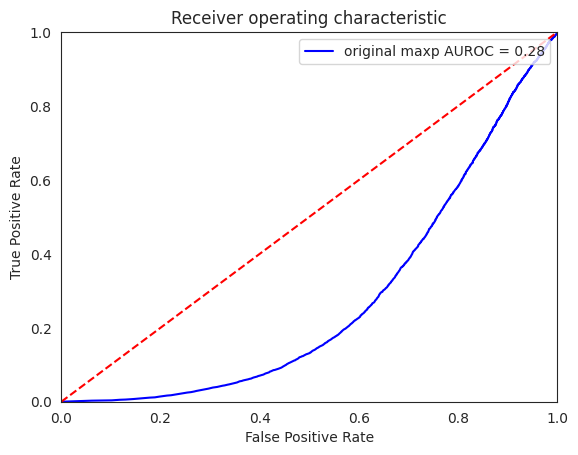

In [39]:
plot_roc(y_true,maxp,"original maxp")

In [40]:
#原始样本视为正样本， 攻击样本视为负样本
y_true2 = [0]*len(maxp_list[0])+[1]*len(maxp_list[1])
maxp2 = np.concatenate([maxp_list[0],maxp_list[1]])*-1
random_pred2 = np.random.rand(len(y_true2))

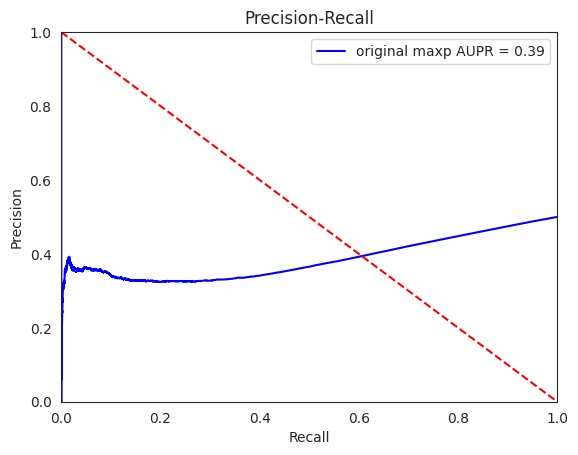

In [41]:
plot_pr(y_true2,maxp2,"original maxp")

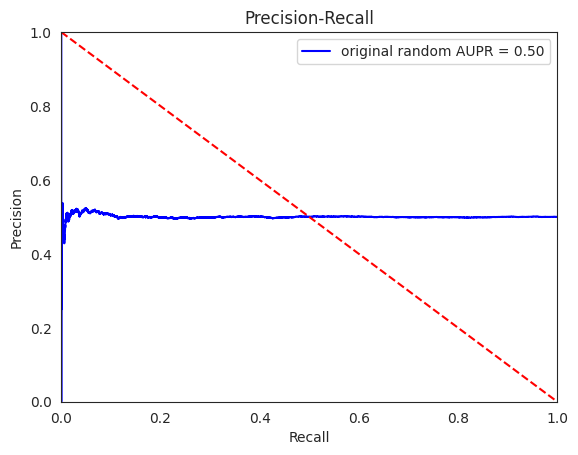

In [42]:
plot_pr(y_true2,random_pred2,"original random")

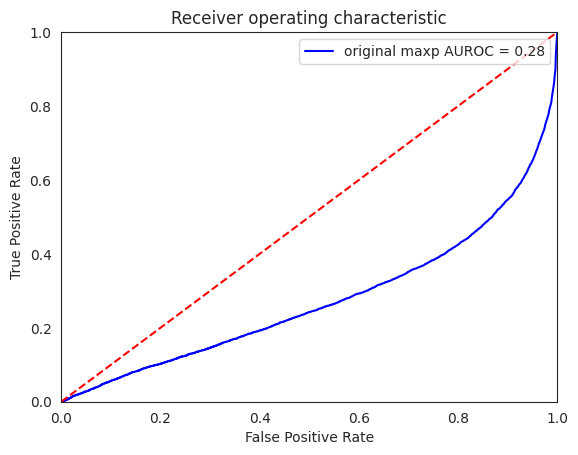

In [43]:
plot_roc(y_true2,maxp2,"original maxp")

### Test time augmentation

In [44]:
datanames = ["cifar10", "mnist","fashionmnist","svhn"]
probs_list = []
for dataname in datanames:
    val_transform = transforms.Compose(
        [
            transforms.PILToTensor(), #返回torch.uint8
            transforms.Resize([32,32]),
        ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(1,transforms.Lambda(lambda x:x.repeat(3,1,1)))
        
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)

    probs = test_time_aug_predict(val_loader, model, device)
    probs_list.append(probs.cpu().detach().numpy())

 * Time 0.058 Acc@1 94.520


AttributeError: 'tuple' object has no attribute 'cpu'

In [ ]:
mi_list = []
for i, probs in enumerate(probs_list):
    mi = mutual_info(probs)
    mi_list.append(mi)

In [ ]:
entropy_list = []
for i, probs in enumerate(probs_list):
    probs = np.mean(probs,axis=1)
    ent = Shannon_entropy(probs)
    entropy_list.append(ent)

In [ ]:
#绘制熵的分布
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("white")
for i , data in  enumerate(entropy_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
#绘制互信息的分布
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("whitegrid")
for i , data in  enumerate(mi_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(5, 10))
sns.set_style("white")
for i , mi in enumerate(mi_list):
    axes[i].set_ylim(0,1)
    axes[i].set_xlabel(datanames[i])
    sns.violinplot(
        mi,
        ax=axes[i],
    )

plt.tight_layout()
plt.show()

In [ ]:
##IND样本视为正样本， mnist样本视为负样本
y_true = [1]*len(mi_list[0])+[0]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]])*-1

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

In [ ]:
##IND样本视为负样本， mnist样本视为正样本
y_true = [0]*len(mi_list[0])+[1]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]])

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

## MC dropout

In [ ]:
print(model.classifier[2].training)
model.classifier[2].training = True  # 打开test dropout
print(model.classifier[2].training)

In [ ]:
datanames = ["cifar10","mnist", "fashionmnist","svhn"]
probs_list = []
for dataname in datanames:
    val_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
    ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(2,transforms.Lambda(lambda x:x.repeat(3,1,1)))
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)

    probs = mc_dropout_predict(val_loader, model, device, 8)
    probs_list.append(probs.cpu().detach().numpy())

In [ ]:
mi_list = []
for i, probs in enumerate(probs_list):
    mi = mutual_info(probs)
    mi_list.append(mi)

In [ ]:
entropy_list = []
for i, probs in enumerate(probs_list):
    probs = np.mean(probs,axis=1)
    ent = Shannon_entropy(probs)
    entropy_list.append(ent)

In [ ]:
#绘制熵的分布
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("white")
for i , data in  enumerate(entropy_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
#绘制互信息的分布
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("whitegrid")
for i , data in  enumerate(mi_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(5, 10))
sns.set_style("white")
for i , mi in enumerate(mi_list):
    axes[i].set_ylim(0,0.06)
    axes[i].set_xlabel(datanames[i])
    sns.violinplot(
        mi,
        ax=axes[i],
    )

plt.tight_layout()
plt.show()

In [ ]:
##IND样本视为正样本， mnist样本视为负样本
y_true = [1]*len(mi_list[0])+[0]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]])*-1

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

In [ ]:
##IND样本视为负样本， mnist样本视为正样本
y_true = [0]*len(mi_list[0])+[1]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]]) 

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

## deep Ensembles

In [ ]:
datanames = ["cifar10","mnist", "fashionmnist","svhn"]
probs_list = []
models_path = ["../saved_models/deterministic/vgg16/2023_11_15_16_36_44/vgg16_best_model_91.78.pth",
               "../saved_models/deterministic/vgg16/2023_11_15_21_15_51/vgg16_best_model_92.90.pth"]
vgg_ensemble = EnsembleModel("vgg16", models_path, device)
for dataname in datanames:
    val_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
    ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(2,transforms.Lambda(lambda x:x.repeat(3,1,1)))
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)

    probs = deep_ensembel_predict(val_loader, vgg_ensemble,  device)
    probs_list.append(probs.cpu().detach().numpy())

In [ ]:
mi_list = []
for i, probs in enumerate(probs_list):
    mi = mutual_info(probs)
    mi_list.append(mi)

In [ ]:
entropy_list = []
for i, probs in enumerate(probs_list):
    probs = np.mean(probs,axis=1)
    ent = Shannon_entropy(probs)
    entropy_list.append(ent)

In [ ]:
#绘制熵的分布
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("white")
for i , data in  enumerate(entropy_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
#绘制互信息的分布
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("whitegrid")
for i , data in  enumerate(mi_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(5, 10))
sns.set_style("white")
for i , mi in enumerate(mi_list):
    axes[i].set_ylim(0,1)
    axes[i].set_xlabel(datanames[i])
    sns.violinplot(
        mi,
        ax=axes[i],
    )

plt.tight_layout()
plt.show()

In [ ]:
##IND样本视为正样本， mnist样本视为负样本
y_true = [1]*len(mi_list[0])+[0]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]])*-1

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

In [ ]:
##IND样本视为负样本， mnist样本视为正样本
y_true = [0]*len(mi_list[0])+[1]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]]) 

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

## Bayesian Neural Network(SVI)

In [ ]:
datanames = ["cifar10","mnist","fashionmnist","svhn"]
model = get_model("resnet50", 10)
const_bnn_prior_parameters = {
    "prior_mu": 0.0,
    "prior_sigma": 1.0,
    "posterior_mu_init": 0.0,
    "posterior_rho_init": -3.0,
    "type":  "Reparameterization",## Flipout or Reparameterization
    "moped_enable": "",  # initialize mu/sigma from the dnn weights
    "moped_delta": 0.5,
}
dnn_to_bnn(model, const_bnn_prior_parameters)
model = model.to(device)
model.eval()
checkpoint = torch.load("../saved_models/bayesian/resnet50/2023_11_17_20_53_02/resnet50_best_model_93.57.pth")
model.load_state_dict(checkpoint['state_dict'])

In [ ]:
probs_list = []
for dataname in datanames:
    val_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
    ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(2,transforms.Lambda(lambda x:x.repeat(3,1,1)))
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)

    probs = bnn_svi_predict(val_loader, model,  device,20)
    probs_list.append(probs.cpu().detach().numpy())

In [ ]:
mi_list = []
for i, probs in enumerate(probs_list):
    mi = mutual_info(probs)
    mi_list.append(mi)

In [ ]:
entropy_list = []
for i, probs in enumerate(probs_list):
    probs = np.mean(probs,axis=1)
    ent = Shannon_entropy(probs)
    entropy_list.append(ent)

In [ ]:
#绘制熵的分布
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("white")
for i , data in  enumerate(entropy_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
#绘制互信息的分布
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("whitegrid")
for i , data in  enumerate(mi_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(5, 10))
sns.set_style("white")
for i , mi in enumerate(mi_list):
    axes[i].set_ylim(0,1)
    axes[i].set_xlabel(datanames[i])
    sns.violinplot(
        mi,
        ax=axes[i],
    )

plt.tight_layout()
plt.show()

In [ ]:
##IND样本视为正样本， mnist样本视为负样本
y_true = [1]*len(mi_list[0])+[0]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]])*-1

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

In [ ]:
##IND样本视为负样本， mnist样本视为正样本
y_true = [0]*len(mi_list[0])+[1]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]])

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)